In [1]:
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 4.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob
import cv2
from sklearn.utils import shuffle
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
import time

%matplotlib inline

/Users/sathya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Downtown', 'Gables', 'Squires', 'UCB', 'Lane']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

data_path = 'Data'
test_path = 'TestData'
checkpoint_dir = "Checkpoint/"

PREPROCESSING DATASET

In [6]:
def normalize_images(images):
    new_images = []
    for image in images:
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        new_images.append(image) 
    #print("NEW IMAGES:", new_images)
    return new_images


In [7]:

def load_data(data_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:  # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(data_path, fld, "*.*")
        files = glob.glob(path)
        
        for fl in files:
            image = cv2.imread(fl)
            if image is None:
                print("Error: Unable to load image")
            else:
                pass
            
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)

            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)

            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)

    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls





def load_test(test_path, image_size):
    path = os.path.join(test_path, "*.*")
    files = glob.glob(path)

    X_test = []
    X_test_id = []
    print("Reading test images")

    for fl in files:
        flbase = os.path.basename(fl)
        img = cv2.imread(fl)
        if img is None:
            print("Error: Unable to load image")
        else:
            pass
    
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)

        X_test.append(img)
        X_test_id.append(flbase)


    X_test = np.array(X_test)
    X_test_id = np.array(X_test_id)
        
    X_test = normalize_images(X_test)

    return X_test, X_test_id

'\ndef load_test(test_path, image_size):\n    path = os.path.join(test_path, \'*g\')\n    files = sorted(glob.glob(path))\n\n    X_test = []\n    X_test_id = []\n    print("Reading test images")\n    for fl in files:\n        flbase = os.path.basename(fl)\n        img = cv2.imread(fl)\n        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)\n        X_test.append(img)\n        X_test_id.append(flbase)\n\n    X_test = normalize_image(X_test)\n\n    return X_test, X_test_id\n\n'

In [8]:
def read_train_sets(data_path, image_size, classes, validation_size=0):

    images, labels, ids, cls = load_data(data_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    #print("IMAGES:", images)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_ids = ids[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_ids = ids[validation_size:]
    train_cls = cls[validation_size:]
    
    normalized_train_imgs = normalize_images(train_images)
    normalized_valid_imgs = normalize_images(validation_images)
    
    train = {
        "images": normalized_train_imgs,
        "labels": train_labels,
        "ids": train_ids,
        "classes": train_cls,
    }

    validation = {
        "images": normalized_valid_imgs,
        "labels": validation_labels,
        "ids": validation_ids,
        "classes": validation_cls,
    }
    
    return train, validation


def read_test_set(test_path, image_size):
    images, ids = load_test(test_path, image_size)
    return images, ids

In [ ]:
train, validation = read_train_sets(data_path, img_size, classes, validation_size=validation_size)

print("\n\n", "Size of:")
print("- Training-set:\t\t{}".format(len(train['labels'])))
print("- Validation-set:\t{}".format(len(validation['labels'])))

Reading training images
Loading Downtown files (Index: 0)
Loading Gables files (Index: 1)
Loading Squires files (Index: 2)
Loading UCB files (Index: 3)


 Size of:
- Training-set:		1392
- Validation-set:	189


PLOTTING RANDOM IMAGES

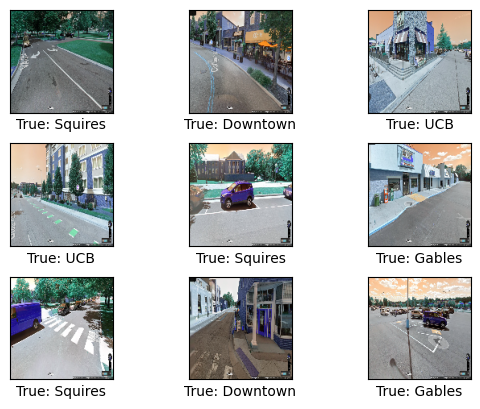

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()



# Get some random images and their labels from the train set.
images, cls_true  = train['images'][:10], train['classes'][:10]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [12]:

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.14.0


In [13]:
DEVICE = "/physical_device:GPU:0"

CNN MODEL

In [86]:
# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(img_size, img_size, num_channels), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flattening layer
model.add(Flatten())

# Dense layer
model.add(Dense(units=128, activation='relu'))

# Dense layer
model.add(Dense(units=64, activation='relu'))

# Output layer
model.add(Dense(num_classes))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003)

# Compile the model with binary cross-entropy loss and accuracy metric
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])

In [87]:
train['images'] = np.array(train['images'])
validation['images'] = np.array(validation['images'])
train['labels'] = np.array(train['labels'])
validation['labels'] = np.array(validation['labels'])

In [88]:
# Train the model
model_checkpoint = ModelCheckpoint(filepath='model_test_24-10-2023_01.h5', monitor='val_loss', save_best_only=True, mode='min')


# Train the model with callbacks
history = model.fit(train['images'], train['labels'], validation_data=(validation['images'], validation['labels']), epochs=200, shuffle=True, 
                    batch_size=8, callbacks=[model_checkpoint])


model.save('model_test_1.h5')

Epoch 1/200


2023-11-28 20:06:12.375292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


195/195 [==============================] - 6s 30ms/step - loss: 1.5010 - accuracy: 0.2916 - val_loss: 1.4300 - val_accuracy: 0.3345
Epoch 2/200
195/195 [==============================] - 5s 27ms/step - loss: 1.3981 - accuracy: 0.3308 - val_loss: 1.3826 - val_accuracy: 0.2736
Epoch 3/200
195/195 [==============================] - 5s 27ms/step - loss: 1.3564 - accuracy: 0.3892 - val_loss: 1.3321 - val_accuracy: 0.5203
Epoch 4/200
195/195 [==============================] - 5s 27ms/step - loss: 1.3113 - accuracy: 0.4843 - val_loss: 1.2782 - val_accuracy: 0.5642
Epoch 5/200
195/195 [==============================] - 5s 28ms/step - loss: 1.2507 - accuracy: 0.5112 - val_loss: 1.2058 - val_accuracy: 0.5709
Epoch 6/200
195/195 [==============================] - 5s 28ms/step - loss: 1.1682 - accuracy: 0.5504 - val_loss: 1.1300 - val_accuracy: 0.5574
Epoch 7/200
195/195 [==============================] - 5s 28ms/step - loss: 1.0911 - accuracy: 0.5890 - val_loss: 1.0724 - val_accuracy: 0.5642
Epoc

In [65]:
print(len(train['images']))
print(len(train['labels']))
print(len(validation['images']))
print(len(validation['labels']))

1557
1557
296
296


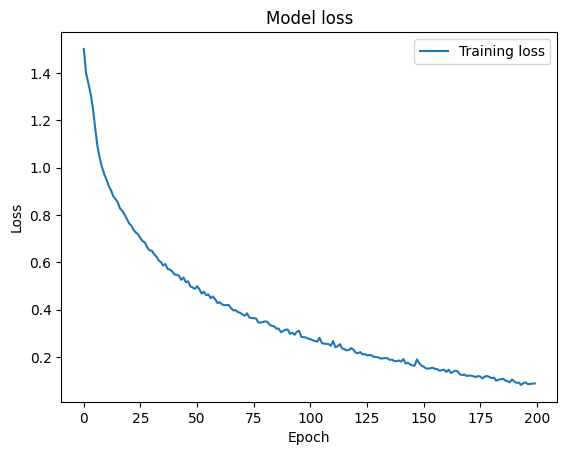

In [89]:
# TRAINING LOSS CURVE

plt.plot(history.history['loss'], label='Training loss')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

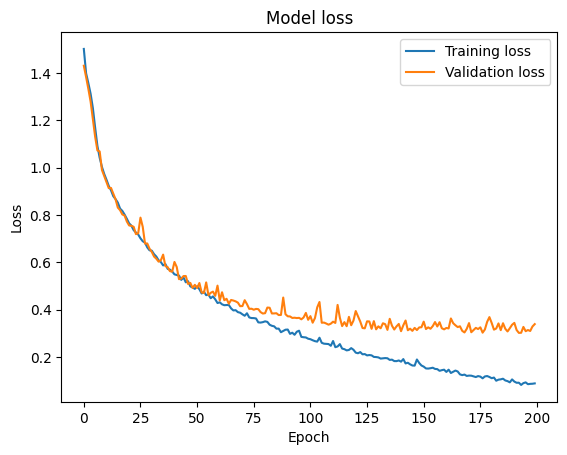

In [90]:
# TRAINING AND VALIDATION LOSS CURVE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

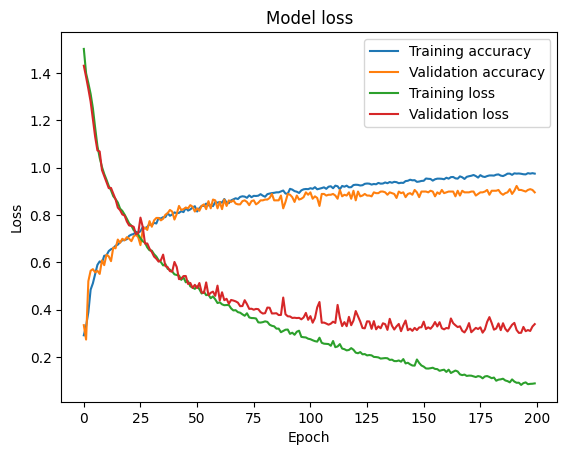

In [91]:
# TRAINING AND VALIDATION LOSS CURVE

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## INFERENCE

In [ ]:
test_images, test_ids = read_test_set(test_path, img_size)

print("\n\n", "Size of:")
print("- Test-set:\t\t{}".format(len(test_images)))

Reading test images


 Size of:
- Test-set:		248


In [ ]:
model.load_weights("model_test_1.h5")

In [ ]:
def predict(test_images, id, printit = False):
    prediction = model.predict(test_images.reshape((1, img_size, img_size, 3)))
    predictedClassNumber = np.argmax(prediction)
    
    if printit:
        print(f"Predicted class: {classes[predictedClassNumber]}")
        print("Actual Class:", {id})

    if (str(classes[predictedClassNumber]) in str(id)):
        actualClassNumber = np.argmax(prediction)
        if printit:
            print("Model Predicted Correctly")
    else:
        i = 0
        for x in classes:
            if str(x) in str(id):
                actualClassNumber = i
            i+=1
        if printit:
            print("Incorrect Prediction")
    
    if printit:
        print("Actual Class Number:", actualClassNumber)
        print("Predicted Class Number:", predictedClassNumber)
        print(" ===============================================")
        print("\n\n")
    
    return actualClassNumber,  predictedClassNumber

In [ ]:
predictionClassNumbers = []
actualClassNumbers = []
for i in range(len(test_images)):
    actualClassNumber, predictionClassNumber = predict(test_images[i], test_ids[i])
    actualClassNumbers.append(actualClassNumber)
    predictionClassNumbers.append(predictionClassNumber)

1/1 [==============================] - 0s 18ms/step


In [ ]:
predictionClassNumbers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 3,
 1,
 3,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 3,
 0,
 0,
 3,
 2,
 0,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 2,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 2,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 3,
 3,
 0,
 2,
 3,
 0,
 1,
 0,
 0,
 2,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3]

In [ ]:
actualClassNumbers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

### Confusion Matrix

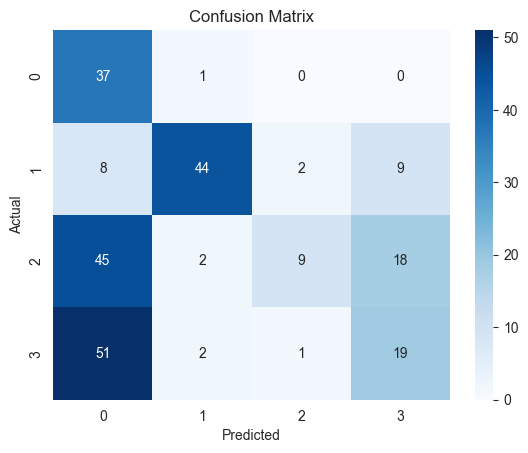

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(actualClassNumbers, predictionClassNumbers)

#print(len(y_pred_binary_new))
#print(y_test)

# Plot the confusion matrix
sns.set_style('whitegrid')
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### RESULTS

In [ ]:
predict(test_images[14], test_ids[14], printit = True)
predict(test_images[25], test_ids[25], printit = True)
predict(test_images[35], test_ids[35], printit = True)
predict(test_images[88], test_ids[88], printit = True)

1/1 [==============================] - 0s 20ms/step
Predicted class: Downtown
Actual Class: {'DowntownTest22.png'}
Model Predicted Correctly
Actual Class Number: 0
Predicted Class Number: 0



1/1 [==============================] - 0s 22ms/step
Predicted class: Downtown
Actual Class: {'DowntownTest32.png'}
Model Predicted Correctly
Actual Class Number: 0
Predicted Class Number: 0



1/1 [==============================] - 0s 19ms/step
Predicted class: Downtown
Actual Class: {'DowntownTest7.png'}
Model Predicted Correctly
Actual Class Number: 0
Predicted Class Number: 0



1/1 [==============================] - 0s 18ms/step
Predicted class: Downtown
Actual Class: {'GablesTest55.png'}
Incorrect Prediction
Actual Class Number: 1
Predicted Class Number: 0





(1, 0)